# Assignment

In [ ]:
%pip install numpy pandas matplotlib

In [2]:
# Import
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Chess_env import *


random.seed(1)
np.random.seed(1)

BOARD_SIZE = 4
NUMBER_OF_EPISODES = 10_000

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [3]:
## INITIALISE THE ENVIRONMENT
regular_chess_environment = Chess_Env(BOARD_SIZE)
regular_board, regular_X, regular_allowed_a = regular_chess_environment.Initialise_game()
regular_n_possible_actions = np.shape(regular_allowed_a)[0]  # TOTAL NUMBER OF POSSIBLE ACTIONS
regular_input_size = np.shape(regular_X)[0]  ## INPUT SIZE

## INITIALIZE ENVIRONMENT WITH IMPROVED REWARDS
improved_chess_environment = Chess_Env(BOARD_SIZE, R=-0.01, R_draw=-1.0, R_checked=1.0)
improved_board, improved_X, improved_allowed_a = improved_chess_environment.Initialise_game()
improved_n_possible_actions = np.shape(improved_allowed_a)[0]  # TOTAL NUMBER OF POSSIBLE ACTIONS
improved_input_size = np.shape(improved_X)[0]  ## INPUT SIZE

## INITIALIZE ENVIRONMENT WITH MINIMAL INFORMATION
minimal_chess_environment = Chess_Env(BOARD_SIZE, extended_features=False)
minimal_board, minimal_X, minimal_allowed_a = minimal_chess_environment.Initialise_game()
minimal_n_possible_actions = np.shape(minimal_allowed_a)[0]  # TOTAL NUMBER OF POSSIBLE ACTIONS
minimal_input_size = np.shape(minimal_X)[0]  ## INPUT SIZE

In [4]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

def random_test(environment):
    S, X, allowed_a = environment.Initialise_game()  # INTIALISE GAME

    print(S)  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

    print('check? ', environment.check)  # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
    print('dofk2 ', np.sum(environment.dfk2_constrain).astype(int))  # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO

    for i in range(5):

        a, _ = np.where(allowed_a == 1)  # FIND WHAT THE ALLOWED ACTIONS ARE
        a_agent = np.random.permutation(a)[0]  # MAKE A RANDOM ACTION

        S, X, allowed_a, R, Done = environment.OneStep(a_agent)  # UPDATE THE ENVIRONMENT

        ## PRINT CHESS BOARD AND VARIABLES
        print('')
        print(S)
        print(R, '', Done)
        print('check? ', environment.check)
        print('dofk2 ', np.sum(environment.dfk2_constrain).astype(int))

        # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
        if Done:
            break

In [5]:
random_test(environment=regular_chess_environment)

[[3 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 2 0]]
check?  0
dofk2  1

[[0 3 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 0 2]]
0  0
check?  0
dofk2  1

[[0 0 3 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 2 0 0]]
0  0
check?  0
dofk2  2

[[0 0 0 0]
 [0 0 3 0]
 [0 0 0 0]
 [0 2 1 0]]
0  0
check?  0
dofk2  2

[[0 0 3 0]
 [0 0 0 0]
 [0 2 0 0]
 [0 0 1 0]]
0  0
check?  0
dofk2  1

[[0 0 0 3]
 [0 0 0 0]
 [0 0 0 0]
 [0 2 1 0]]
0  0
check?  0
dofk2  2


In [6]:
def random_game(environment):
    # PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES

    S, X, allowed_a = environment.Initialise_game()
    N_episodes = 1_000

    # VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES
    count = []
    rewards = []

    for n in range(N_episodes):

        S, X, allowed_a = environment.Initialise_game()  # INITIALISE GAME
        Done = 0  # SET Done=0 AT THE BEGINNING
        i = 1  # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE

        # UNTIL THE EPISODE IS NOT OVER...(Done=0)
        while Done == 0:

            # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES

            a, _ = np.where(allowed_a == 1)
            a_agent = np.random.permutation(a)[0]

            S, X, allowed_a, R, Done = environment.OneStep(a_agent)

            if Done:
                count.append(R)
                rewards.append(i)
                break

            i = i + 1  # UPDATE THE COUNTER
    return count, rewards

In [7]:
# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)
random_count, random_rewards = random_game(environment=regular_chess_environment)
print('Random_Agent, Average reward:', np.mean(random_count), 'Number of steps: ', np.mean(random_rewards))

Random_Agent, Average reward: 0.196 Number of steps:  7.297


## Task 3
The following is an implementation of a general **Neural Network Class** and a reinforcement learner using **SARSA**.

In [66]:
class Network:
    W1, W2 = None, None

    def __init__(self, hidden_layer, input_dim, output_dim, eta=0.02, rho=0.99, rmsprop=False):
        # Xavier initialization
        self.W1 = np.random.randn(hidden_layer + 1, input_dim + 1) * 1.0 / np.sqrt(input_dim + 1)
        self.W2 = np.random.randn(output_dim, hidden_layer + 1) * 1.0 / np.sqrt(hidden_layer + 1)
        # Step size
        self.eta = eta
        # RMSprop parameters
        self.rho = rho
        self.V1 = np.zeros(self.W1.shape)
        self.V2 = np.zeros(self.W2.shape)
        self.l1 = None
        self.l2 = None
        self.rmsprop = rmsprop
       
    @staticmethod
    def relu(A):
        return np.maximum(0, A)

    @staticmethod
    def gradient(X, T, Y, H, W2, Z1, Z2):
        # Add bias term
        X_bias = np.vstack((np.ones(X.shape[1]), X))

        # d Loss / d Y
        G_Y = 2. * (Y - T)
        # d Y / d Z2
        G_Z2 = G_Y * np.maximum(0, np.sign(Z2))
        # d Z2 / d W2
        G_W2 = np.dot(G_Z2, H.T)
        # Layer 2 gradient
        G2 = (1. / X_bias.shape[1]) * G_W2

        # d Z2 / d H
        G_H = np.dot(W2.T, G_Z2)
        # d H / d Z1
        G_Z1 = G_H * np.maximum(0, np.sign(Z1))
        # d Z1 / d W1
        G_W1 = np.dot(G_Z1, X_bias.T)
        # Layer 1 gradient
        G1 = (1. / X_bias.shape[1]) * G_W1
        return G1, G2

    def descent(self, X, T, H, Y, Z1, Z2):
        G1, G2 = Network.gradient(X, T, Y, H, self.W2, Z1, Z2)

        if self.rmsprop:
            self.V1 = (self.rho * self.V1) + ((1.0 - self.rho) * np.square(G1))
            print(G1, np.min(G1), np.max(G1))
            self.V2 = (self.rho * self.V2) + ((1.0 - self.rho) * np.square(G2))

            # print(np.dot(G1, (G1 / (np.sqrt(self.V1) + 1e-7)).T))
            print("Under wurzel", (np.sqrt(self.V1) + 1e-7))
            print("Multi", (G1 / (np.sqrt(self.V1) + 1e-7)))
            print("reduction", self.eta * (G1 / (np.sqrt(self.V1) + 1e-7)))
            print("min w1, max w1", np.min(self.W1), np.max(self.W1))
            print("min w2, max w2", np.min(self.W2), np.max(self.W2))

            self.W1 = self.W1 - self.eta * (G1 / (np.sqrt(self.V1) + 1e-7))
            self.W2 = self.W2 - self.eta * (G2 / (np.sqrt(self.V2) + 1e-7))
        else:
            self.W1 -= self.eta * G1
            self.W2 -= self.eta * G2

    def forward(self, X):
        # Add Bias to first layer input
        X_bias = np.vstack((np.ones(X.shape[1]), X))
        # First Layer
        Z1 = np.dot(self.W1, X_bias)
        H = Network.relu(Z1)
        # Fix Bias for second layer input
        H[0, :] = 1.
        # Second Layer
        Z2 = np.dot(self.W2, H)
        Y = Network.relu(Z2)
        return Y, H, Z1, Z2

In [9]:
def epsilon_greedy_policy(Qvalues, epsilon):
    N_class = np.shape(Qvalues)[0]
    batch_size = np.shape(Qvalues)[1]

    rand_values = np.random.uniform(0, 1, [batch_size])

    rand_a = rand_values < epsilon
    a = np.zeros([batch_size, N_class])

    for i in range(batch_size):
        if rand_a[i]:
            valid_moves = np.where(Qvalues[:,i] > -1000)[0]
            chosen = np.random.choice(valid_moves)
            a[i, chosen] = 1
        else:
            a[i, np.argmax(Qvalues[:, i])] = 1

    return a

In [10]:
def test(network, environment, number_of_episodes):
    nr_moves = []
    total_rewards = []
    stuck_runs = 0
    for i in range(number_of_episodes):
	    done = 0
	    S, X, allowed_a = environment.Initialise_game()
	    X = X.reshape(len(X), 1)
	    total_reward = 0
	    count = 0
	    while done == 0:
		    count += 1
		    Q_values, _, _, _ = network.forward(X)
		    masked_Q_values = Q_values - (1 - allowed_a) * 100000
		    a_agent = epsilon_greedy_policy(masked_Q_values, 0).T
		    S, X, allowed_a, R, done = environment.OneStep(np.argmax(a_agent))
		    X = np.array(X).reshape(len(X),1)
		    total_reward += R
		    if count > 100:
			    stuck_runs += 1
			    break
	    nr_moves.append(count)
	    total_rewards.append(total_reward)
    return nr_moves, total_rewards, stuck_runs

In [11]:
def sarsa(environment, network, number_of_episodes, epsilon, B, y):
    count = []
    rewards = []

    for n in range(number_of_episodes):

        epsilon_f = epsilon / (1 + B * n)  ## DECAYING EPSILON
        Done = 0  ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1  ## COUNTER FOR NUMBER OF ACTIONS
        total_reward = 0 ## COUNTER FOR TOTAL REWARD

        S, X, allowed_a = environment.Initialise_game()  ## INITIALISE GAME
        X = X.reshape(len(X), 1)

        if n > 0 and n % 100 == 0:
            print(f"\rEp.: {n}, epsilon: {epsilon_f:.3f}, moves: {np.mean(count[n - 100:]):.2f}", end="")

        Q_values, H, Z1, Z2 = network.forward(X)
        masked_Q_values = Q_values - (1 - allowed_a) * 100000
        a_agent = epsilon_greedy_policy(masked_Q_values, epsilon_f).T

        while Done == 0:  ## START THE EPISODE

            S_next, X_next, allowed_a_next, R, Done = environment.OneStep(np.argmax(a_agent))
            X_next = np.array(X_next).reshape(len(X_next), 1)
            
            total_reward += R

            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done == 1:
                output = Q_values * a_agent
                target = R * a_agent
                network.descent(X, target, H, output, Z1, Z2)
                count.append(i)
                rewards.append(total_reward)
                break

            # IF THE EPISODE IS NOT OVER...
            else:
                Q_values_next, H_next, Z1_next, Z2_next = network.forward(X_next)
                masked_Q_values_next = Q_values_next - (1 - allowed_a_next) * 100000
                a_agent_next = epsilon_greedy_policy(masked_Q_values_next, epsilon_f).T
                future_R = Q_values_next[np.argmax(a_agent_next)]
                output = Q_values * a_agent
                target = (R + y * future_R) * a_agent
                network.descent(X, target, H, output, Z1, Z2)

            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
            Q_values = np.copy(Q_values_next)
            H = np.copy(H_next)
            a_agent = np.copy(a_agent_next)
            Z1 = np.copy(Z1_next)
            Z2 = np.copy(Z2_next)

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    return count, rewards

In [12]:
## INITALISE YOUR NEURAL NETWORK...
network_sarsa = Network(hidden_layer=200, input_dim=regular_input_size, output_dim=regular_n_possible_actions, eta=0.0035)

In [13]:
sarsa_count, sarsa_rewards = sarsa(environment=regular_chess_environment, network=network_sarsa, number_of_episodes=NUMBER_OF_EPISODES, epsilon=0.2, B=0.00005, y=0.85)
print('\nSARSA Agent training, Average reward:', np.mean(sarsa_rewards), 'Number of steps: ', np.mean(sarsa_count))
nr_moves_sarsa_test, rewards_sarsa_test, stucks_sarsa_test = test(network=network_sarsa, environment=regular_chess_environment, number_of_episodes=5_000)
print('\nSARSA Agent testing, Average reward:', np.mean(rewards_sarsa_test), 'Number of steps: ', np.mean(nr_moves_sarsa_test), 'Nr of stucks: ', stucks_sarsa_test)

Ep.: 9900, epsilon: 0.134, moves: 3.49
SARSA Agent training, Average reward: 0.7608 Number of steps:  4.7772

SARSA Agent testing, Average reward: 0.9706 Number of steps:  3.0644 Nr of stucks:  4


### Plot 1: Reward per Game over Time

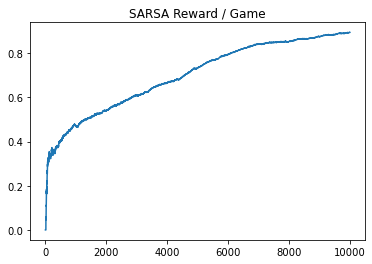

In [14]:
ema_moves = pd.DataFrame(sarsa_rewards).ewm(halflife=1000).mean()
plt.figure()
plt.title("SARSA Reward / Game")
plt.plot(ema_moves)
plt.show()

### Plot 2: Number of Moves per Game vs. training Time

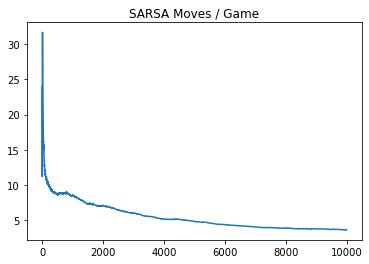

In [15]:
ema_moves = pd.DataFrame(sarsa_count).ewm(halflife=1000).mean()
plt.figure()
plt.title("SARSA Moves / Game")
plt.plot(ema_moves)
plt.show()

## Task 4
We changed increased **epsilon_0 to 0.4**, decreased **gamma to 0.7**, decreased **beta to 0.0001**, increased **eta to 0.02** and increased the number of **hidden layers to 256**.

In [16]:
## INITALISE YOUR NEURAL NETWORK...
network_adapted_sarsa = Network(hidden_layer=256, input_dim=regular_input_size, output_dim=regular_n_possible_actions, eta=0.02 )

In [17]:
adapted_sarsa_count, adapted_sarsa_rewards = sarsa(environment=regular_chess_environment, network=network_adapted_sarsa, number_of_episodes=NUMBER_OF_EPISODES, epsilon=0.4, B=0.0001, y=0.7)
print('\nAdapted SARSA Agent training, Average reward:', np.mean(adapted_sarsa_rewards), 'Number of steps: ', np.mean(adapted_sarsa_count))
nr_moves_adapted_sarsa_test, rewards_adapted_sarsa_test, stucks_adapted_sarsa_test = test(network=network_adapted_sarsa, environment=regular_chess_environment, number_of_episodes=5_000)
print('\nAdapted SARSA Agent testing, Average reward:', np.mean(rewards_adapted_sarsa_test), 'Number of steps: ', np.mean(nr_moves_adapted_sarsa_test), 'Nr of stucks: ', stucks_adapted_sarsa_test)

Ep.: 9900, epsilon: 0.201, moves: 3.24
Adapted SARSA Agent training, Average reward: 0.6155 Number of steps:  5.2612

Adapted SARSA Agent testing, Average reward: 0.9508 Number of steps:  3.4714 Nr of stucks:  48


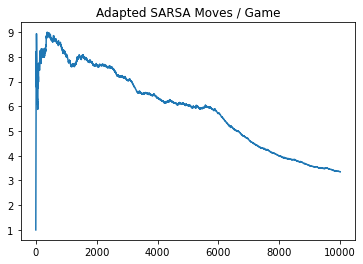

In [18]:
ema_moves = pd.DataFrame(adapted_sarsa_count).ewm(halflife=1000).mean()
plt.figure()
plt.title("Adapted SARSA Moves / Game")
plt.plot(ema_moves)
plt.show()

## Task 5
We implemented **Q-Learning** and **Experience Replay** as well.

### Q-Learning

In [19]:
def qlearn(environment, network, number_of_episodes, epsilon, B, y):
    count = []
    rewards = []
    
    for n in range(number_of_episodes):

        epsilon_f = epsilon / (1 + B * n)  ## DECAYING EPSILON
        Done = 0  ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1  ## COUNTER FOR NUMBER OF ACTIONS
        total_reward = 0 ## COUNTER FOR TOTAL REWARD

        S, X, allowed_a = environment.Initialise_game()  ## INITIALISE GAME
        X = X.reshape(len(X), 1)

        if n > 0 and n % 100 == 0:
            print(f"\rEp.: {n}, epsilon: {epsilon_f:.3f}, moves: {np.mean(count[n - 100:]):.2f}", end="")

        Q_values, H, Z1, Z2 = network.forward(X)
        masked_Q_values = Q_values - (1 - allowed_a) * 100_000
        a_agent = epsilon_greedy_policy(masked_Q_values, epsilon_f).T

        while Done == 0:  ## START THE EPISODE

            S_next, X_next, allowed_a_next, R, Done = environment.OneStep(np.argmax(a_agent))
            X_next = np.array(X_next).reshape(len(X_next), 1)
            total_reward += R

            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done == 1:
                output = Q_values * a_agent
                target = R * a_agent
                network.descent(X, target, H, output, Z1, Z2)
                count.append(i)
                rewards.append(total_reward)
                break

            # IF THE EPISODE IS NOT OVER...
            else:
                Q_values_next, H_next, Z1_next, Z2_next = network.forward(X_next)
                masked_Q_values_next = Q_values_next - (1 - allowed_a_next) * 100_000
                # Q-Learning chooses the next step greedily (epsilon=0)
                a_agent_next = epsilon_greedy_policy(masked_Q_values_next, 0.0).T
                future_R = Q_values_next[np.argmax(a_agent_next)]
                output = Q_values * a_agent
                target = (R + y * future_R) * a_agent
                network.descent(X, target, H, output, Z1, Z2)

            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
            Q_values = np.copy(Q_values_next)
            H = np.copy(H_next)
            Z1 = np.copy(Z1_next)
            Z2 = np.copy(Z2_next)
            # Q-Learning chooses next action based on greedy policty
            a_agent = epsilon_greedy_policy(masked_Q_values_next, epsilon_f).T

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    return count, rewards

In [20]:
## INITALISE YOUR NEURAL NETWORK...
network_qlearn = Network(hidden_layer=256, input_dim=regular_input_size, output_dim=regular_n_possible_actions, eta=0.02)

In [21]:
qlearn_count, qlearn_rewards = qlearn(environment=regular_chess_environment, network=network_qlearn, number_of_episodes=NUMBER_OF_EPISODES, epsilon=0.4, B=0.0001, y=0.7)
print('\nAdapted Q-Learning Agent, Average reward:', np.mean(qlearn_rewards), 'Number of steps: ', np.mean(qlearn_count))
nr_moves_q_test, rewards_q_test, stucks_q_test = test(network=network_qlearn, environment=regular_chess_environment, number_of_episodes=5_000)
print('\nAdapted Q-Learning Agent testing, Average reward:', np.mean(rewards_q_test), 'Number of steps: ', np.mean(nr_moves_q_test), 'Nr of stucks: ', stucks_q_test)

Ep.: 4100, epsilon: 0.284, moves: 3.38

KeyboardInterrupt: 

In [ ]:
ema_moves = pd.DataFrame(qlearn_count).ewm(halflife=1000).mean()
plt.figure()
plt.title("Adapted Q-Learning Moves / Game")
plt.plot(ema_moves)
plt.show()

### Experience Replay

In [ ]:
class Experience:
    def __init__(self, state_before, state_after, action, reward):
        self.state_before = state_before
        self.state_after = state_after
        self.action = action
        self.reward = reward

In [ ]:
def replay(environment, network, number_of_episodes, epsilon, B, y, batch_size=50, relevant_histories=300):
    count = []
    rewards = []
    
    experiences = []
    
    for n in range(int(number_of_episodes/5)):

        epsilon_f = epsilon / (1 + B * n)  ## DECAYING EPSILON

        Done = 0  ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1  ## COUNTER FOR NUMBER OF ACTIONS
        total_reward = 0 ## COUNTER FOR TOTAL REWARD

        S, X, allowed_a = environment.Initialise_game()  ## INITIALISE GAME
        X = X.reshape(len(X), 1)

        if n > 0 and n % 100 == 0:
            print(f"\rEp.: {n}, epsilon: {epsilon_f:.3f}, moves: {np.mean(count[n - 100:]):.2f}", end="")

        while Done == 0:  ## START THE EPISODE
            
            Q_values, H, Z1, Z2 = network.forward(X)
            masked_Q_values = Q_values - (1 - allowed_a) * 100_000
            a_agent = epsilon_greedy_policy(masked_Q_values, epsilon_f).T

            S_next, X_next, allowed_a_next, R, Done = regular_chess_environment.OneStep(np.argmax(a_agent))
            X_next = np.array(X_next).reshape(len(X_next), 1)
            total_reward += R
            
            if X_next.shape[0] == 0:
                expi = Experience(X, X, a_agent, R)
            else:
                expi = Experience(X, X_next, a_agent, R)
            experiences.append(expi)
            
            if len(experiences) > relevant_histories:
                experiences = experiences[1:]
                training_set = np.random.choice(experiences, batch_size, False)
                
                state_before = np.hstack([experience.state_before for experience in training_set])
                Q_values_before, H_before, Z1_before, Z2_before = network.forward(state_before)
                
                actions = np.hstack([experience.action for experience in training_set])
                Q_values_played = Q_values_before * actions
                
                states_after = np.hstack([experience.state_after for experience in training_set])
                Q_values_after, _, _, _ = network.forward(states_after)

                Q_values_after_played = np.max(Q_values_after, 0)
                
                rewards_played = np.hstack([experience.reward for experience in training_set])
                
                target = (rewards_played + y * Q_values_after_played) * actions
                network.descent(state_before, target, H_before, Q_values_played, Z1_before, Z2_before)
                
            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done == 1:
                count.append(i)
                rewards.append(total_reward)
                break
                
            allowed_a = np.copy(allowed_a_next)
            X = np.copy(X_next)

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    return count, rewards

In [ ]:
## INITALISE YOUR NEURAL NETWORK...
network_replay = Network(hidden_layer=256, input_dim=regular_input_size, output_dim=regular_n_possible_actions, eta=0.02)

In [ ]:
replay_count, replay_rewards = replay(environment=regular_chess_environment, network=network_replay, number_of_episodes=NUMBER_OF_EPISODES, epsilon=0.4, B=0.0001, y=0.7)
print('\nExperience Replay Agent training, Average reward:', np.mean(replay_rewards), 'Number of steps: ', np.mean(replay_count))
nr_moves_er_test, rewards_er_test, stucks_er_test = test(network=network_replay, environment=regular_chess_environment, number_of_episodes=5_000)
print('\nExperience Replay Agent testing, Average reward:', np.mean(rewards_er_test), 'Number of steps: ', np.mean(nr_moves_er_test), 'Nr of stucks: ', stucks_er_test)

In [ ]:
ema_moves = pd.DataFrame(replay_count).ewm(halflife=1000).mean()
plt.figure()
plt.title("Experience Replay Moves / Game")
plt.plot(ema_moves)
plt.show()

## Task 6a
We changed the administration of rewards as follows: Every regular action / move gets a slight punishment of -0.01, while a checkmate results in a reward of 1.0 and stale in a punishment of -1.0.


In [ ]:
## INITALISE YOUR NEURAL NETWORK...
improved_qlearn_network = Network(hidden_layer=256, input_dim=improved_input_size, output_dim=improved_n_possible_actions, eta=0.02)

In [ ]:
improved_count, improved_rewards = qlearn(environment=improved_chess_environment, network=improved_qlearn_network, number_of_episodes=NUMBER_OF_EPISODES, epsilon=0.4, B=0.0001, y=0.7)
print('\nLess-Information Q-Learning Agent training, Average reward:', np.mean(improved_rewards), 'Number of steps: ', np.mean(improved_count))
nr_moves_minimal, reward_minimal, stuck_minimal = test(network=improved_qlearn_network, environment=improved_chess_environment, number_of_episodes=5_000)
print('\nLess-Information Q-Learning Agent testing, Average reward:', np.mean(reward_minimal), 'Number of steps: ', np.mean(nr_moves_minimal), 'Nr of stucks: ', stuck_minimal)

In [ ]:
ema_moves = pd.DataFrame(improved_count).ewm(halflife=1000).mean()
plt.figure()
plt.title("Less-Information Q-Learning Moves / Game")
plt.plot(ema_moves)
plt.show()

## Task 6b
We removed the additional input in the state representation (number of possible moves for opponent king, information about checked-state).

In [ ]:
## INITALISE YOUR NEURAL NETWORK...
minimal_network = Network(hidden_layer=256, input_dim=minimal_input_size, output_dim=minimal_n_possible_actions, eta=0.02)

In [ ]:
minimal_count, minimal_rewards = qlearn(environment=minimal_chess_environment, network=minimal_network, number_of_episodes=NUMBER_OF_EPISODES, epsilon=0.4, B=0.0001, y=0.7)
print('\nLess-Information Q-Learning Agent training, Average reward:', np.mean(minimal_rewards), 'Number of steps: ', np.mean(minimal_count))
nr_moves_minimal, reward_minimal, stuck_minimal = test(network=minimal_network, environment=minimal_chess_environment, number_of_episodes=5_000)
print('\nLess-Information Q-Learning Agent testing, Average reward:', np.mean(reward_minimal), 'Number of steps: ', np.mean(nr_moves_minimal), 'Nr of stucks: ', stuck_minimal)

In [ ]:
ema_moves = pd.DataFrame(minimal_count).ewm(halflife=1000).mean()
plt.figure()
plt.title("Less-Information Q-Learning Moves / Game")
plt.plot(ema_moves)
plt.show()

## Task 7
We implemented RMSProp as part of the Network class.

In [64]:
## INITALISE YOUR NEURAL NETWORK...
network_rmsprop = Network(hidden_layer=256, input_dim=regular_input_size, output_dim=regular_n_possible_actions, eta=0.02, rmsprop=True)

In [65]:
rmsprop_count, rmsprop_rewards = sarsa(environment=regular_chess_environment, network=network_rmsprop, epsilon=0.4, number_of_episodes=1, B=0.0001, y=0.7)
print('\nRMSProp Q-Learning Agent training, Average reward:', np.mean(rmsprop_rewards), 'Number of steps: ', np.mean(rmsprop_count))
# nr_moves_q3_test, rewards_q3_test, stucks_q3_test = test(network=network_rmsprop, environment=regular_chess_environment, number_of_episodes=5_000)
# print('\nRMSProp Q-Learning Agent testing, Average reward:', np.mean(rewards_q3_test), 'Number of steps: ', np.mean(nr_moves_q3_test), 'Nr of stucks: ', stucks_q3_test)

[[-0.         -0.         -0.         ... -0.         -0.
  -0.        ]
 [-0.         -0.         -0.         ... -0.         -0.
  -0.        ]
 [ 0.02908785  0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.03497055 -0.         -0.         ... -0.         -0.
  -0.        ]
 [ 0.01728538  0.          0.         ...  0.          0.
   0.        ]
 [-0.         -0.         -0.         ... -0.         -0.
  -0.        ]] -0.08698336528929326 0.0891000510643951
Under wurzel [[1.00000000e-07 1.00000000e-07 1.00000000e-07 ... 1.00000000e-07
  1.00000000e-07 1.00000000e-07]
 [1.00000000e-07 1.00000000e-07 1.00000000e-07 ... 1.00000000e-07
  1.00000000e-07 1.00000000e-07]
 [2.90888533e-03 1.00000000e-07 1.00000000e-07 ... 1.00000000e-07
  1.00000000e-07 1.00000000e-07]
 ...
 [3.49715512e-03 1.00000000e-07 1.00000000e-07 ... 1.00000000e-07
  1.00000000e-07 1.00000000e-07]
 [1.72863834e-03 1.00000000e-07 1.00000000e-07 ... 1.00000000e-07
  1.00000000e-07 1.00000000e-07]
 [1

In [ ]:
ema_moves = pd.DataFrame(rmsprop_count).ewm(halflife=1000).mean()
plt.figure()
plt.title("RMSProp Q-Learning Moves / Game")
plt.plot(ema_moves)
plt.show()